## Analysing and Preparing Data

###Charging Data

In [2]:
# Basic example loading images from the svhn dataset

# Dictionaries
import scipy.io as sio
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import re
from nltk.corpus import stopwords
import string

# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/Shared drives/DeepLearning_2022/PROJECT/Data/'
results_path = '/content/drive/Shared drives/DeepLearning_2022/PROJECT/Results/'

import csv

# Charge the data

#we read the dataset Sentiment140 for tweet polarity --> 1.6M tweets
data_polarity = pd.read_csv(data_path+'Sentiment140.csv',encoding='utf-8')

#we read the dataset TweetsEmotions for tweet emotions --> 9870 tweets
data_emotion = pd.read_csv(data_path+'TweetsEmotions.csv', index_col = 0)
data_emotion2 = pd.read_csv(data_path+'emotions2.csv', index_col = 0)

#we read the datasets
data_emoji = pd.read_csv(data_path+'emoticons_polarity_emotion_filtered.csv',index_col = 0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Preparing Data Emoji

In [3]:
# Again not all types have the same number of data, dangerous
print(data_emoji)
print(data_emoji["emotion"].value_counts())

                                                  tweet  \
0     The woman who was forced into child labour dur...   
1     A group of children who fled #Mariupol are now...   
2     @MZavala86 @RT_com Dictator Vladimir Putin has...   
3     Yesterday in Brussels during a peaceful strike...   
4     😡 The Russians who left the #Chornobyl nuclear...   
...                                                 ...   
2068  Let’s stop the russian spelling and name it th...   
2069  #Lysychansk after #Putin 🤬 #Лисичанськ #Україн...   
2070  This is really brutal! 🤬\n\nA Ukrainian office...   
2071  Hey #Germany! Are you going to start using #pe...   
2072  Go figure ...India won't condemn Russia for (t...   

                          emoji  polarity  emotion  
0                         ['😭']         0        3  
1                         ['😭']         0        3  
2                         ['😂']         1        1  
3                         ['😓']         0        3  
4                         

In [4]:
data_emoji_0 = data_emoji[data_emoji["polarity"]==0]
data_emoji_0["emotion"].value_counts()

3    496
4    400
6     46
5      5
Name: emotion, dtype: int64

In [5]:
for i,row in data_emoji_0.iterrows():
  if (data_emoji_0.loc[i,"emotion"]==3):
    data_emoji_0.loc[i,"emotion"]=0
  elif (data_emoji_0.loc[i,"emotion"]==4):
    data_emoji_0.loc[i,"emotion"]=1
  elif (data_emoji_0.loc[i,"emotion"]==5):
    data_emoji_0.loc[i,"emotion"]=2
  elif (data_emoji_0.loc[i,"emotion"]==6):
    data_emoji_0.loc[i,"emotion"]=3 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [16]:
data_emoji_0["emotion"].value_counts()

print(data_emoji_0["emotion"].value_counts())
data_emoji_0_s = data_emoji_0[data_emoji_0["emotion"] == 0]
data_emoji_0_a = data_emoji_0[data_emoji_0["emotion"] == 1]
data_emoji_0_f = data_emoji_0[data_emoji_0["emotion"] == 2]
data_emoji_0_d = data_emoji_0[data_emoji_0["emotion"] == 3]

data_emoji_0_s = data_emoji_0_s.sample(n=46)
data_emoji_0_a = data_emoji_0_a.sample(n=46)
data_emoji_0_f = data_emoji_0_f.sample(n=5)
data_emoji_0_d = data_emoji_0_d.sample(n=46)

data_emoji_0 = data_emoji_0_s.append(data_emoji_0_a,ignore_index=True)
data_emoji_0 = data_emoji_0.append(data_emoji_0_f,ignore_index=True)
data_emoji_0 = data_emoji_0.append(data_emoji_0_d,ignore_index=True)

from sklearn.utils import shuffle
data_emoji_0 = shuffle(data_emoji_0)

print(data_emoji_0["emotion"].value_counts())

0    46
1    46
3    46
2     5
Name: emotion, dtype: int64
3    46
1    46
0    46
2     5
Name: emotion, dtype: int64


##Train the model (Ukraine)

In [17]:
import torch.nn as nn
 
class SentimentalLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):    
        """
        Initialize the model by setting up the layers
        """
        super().__init__()
        self.output_size=output_size
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        
        #Embedding and LSTM layers
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.lstm=nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        
        #dropout layer
        self.dropout=nn.Dropout(0.4)
        
        #Linear and sigmoid layer
        self.fc1=nn.Linear(hidden_dim, 64)
        self.fc2=nn.Linear(64, 16)
        self.fc3=nn.Linear(16,output_size)
        self.sigmoid=nn.Sigmoid()
        self.softAct = nn.Softmax()
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size=x.size()
        
        #Embadding and LSTM output
        embedd=self.embedding(x)
        lstm_out, hidden=self.lstm(embedd, hidden)

        #stack up the lstm output
        # lstm_out=lstm_out.contiguous().view(-1, self.hidden_dim)

        #dropout and fully connected layers
        out=self.dropout(lstm_out)
        out=self.fc1(out)
        out=self.dropout(out)
        out=self.fc2(out)
        out=self.dropout(out)
        out=self.fc3(out)
       
        
       # out = self.fc3(out)
        sig_out = self.sigmoid(out)
        sig_out = sig_out[:,-1,:]
        

        '''
        print(out.contiguous().view(-1).shape)
       # sig_out = self.softAct(out[:,-1]).view(batch_size, -1)
        sig_out=out.contiguous().view(-1)
        print(sig_out.shape)
        sig_out=sig_out.view(batch_size,-1)
        print(sig_out.shape)'''
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        """Initialize Hidden STATE"""
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        return (torch.zeros(1, 1, hidden_dim).cuda(),
                torch.zeros(1, 1, hidden_dim).cuda())
        

###Preparing Data Emoji Ukraine

In [18]:
import re
from string import punctuation

all_tweets_emoji_0 = list()

for t in data_emoji_0["tweet"]:
  #t = 'a ' + t
  t = re.sub("(?:\s)@[^, ]*", '', t)
  #t = re.sub("(?:\s)#[^, ]*", '', t)
  t = t[4:]
  t = t.lower()
  t = "".join([ch for ch in t if ch not in punctuation])
  all_tweets_emoji_0.append(t)

all_text = " ".join(all_tweets_emoji_0)
all_words = all_text.split()

In [19]:
from collections import Counter 
# Count all the words using Counter Method
count_words = Counter(all_words)
total_words=len(all_words)
sorted_words=count_words.most_common(total_words)
print("Top ten occuring words : ",sorted_words[:10])

Top ten occuring words :  [('the', 148), ('to', 84), ('ukraine', 74), ('and', 61), ('in', 52), ('of', 45), ('is', 41), ('russia', 39), ('mined', 32), ('a', 31)]


In [20]:
vocab_to_int={w:i+1 for i,(w,c) in enumerate(sorted_words)}

In [21]:
encoded_tweets=list()
iter_1 = 0
iter_2 = 0
for t in all_tweets_emoji_0:
  encoded_tweet=list()
  for word in t.split():
    if word not in vocab_to_int.keys():
      #if word is not available in vocab_to_int put 0 in that place
      encoded_tweet.append(0)
      iter_1 += 1
    else:
      iter_2 += 1
      encoded_tweet.append(vocab_to_int[word])
  encoded_tweets.append(encoded_tweet)
print(iter_1)
print(iter_2)
print(encoded_tweets[0])

0
3480
[7, 5, 3, 80, 104, 239, 240, 105, 241, 177, 116, 1, 242, 80, 243, 244, 245, 62, 33, 246, 12, 247]


In [22]:
sequence_length = 0
for i, tweet in enumerate(encoded_tweets):
  if len(tweet) > sequence_length:
    sequence_length = len(tweet)

features_emoji_0 = []
for i, tweet in enumerate(encoded_tweets):
  tweet_len=len(tweet)
  if (tweet_len<=sequence_length):
    zeros=list(np.zeros(sequence_length-tweet_len))
    new=zeros+tweet
  else:
    new=tweet[:sequence_length]
  features_emoji_0.append(np.array(new))

###Train Model

In [23]:
train_x=features_emoji_0[:int(0.7*len(features_emoji_0))]
train_y=data_emoji_0["emotion"][:int(0.7*len(features_emoji_0))]
valid_x=features_emoji_0[int(0.7*len(features_emoji_0)):int(0.8*len(features_emoji_0))]
valid_y=data_emoji_0["emotion"][int(0.7*len(features_emoji_0)):int(0.8*len(features_emoji_0))]
test_x=features_emoji_0[int(0.8*len(features_emoji_0)):]
test_y=data_emoji_0["emotion"][int(0.8*len(features_emoji_0)):]
print(len(train_y), len(valid_y), len(test_y))

100 14 29


In [27]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

#create Tensor Dataset
train_data=TensorDataset(torch.FloatTensor(train_x).to(torch.int64), F.one_hot(torch.FloatTensor(train_y.to_numpy(dtype=np.float64)).to(torch.int64)))
valid_data=TensorDataset(torch.FloatTensor(valid_x).to(torch.int64), F.one_hot(torch.FloatTensor(valid_y.to_numpy(dtype=np.float64)).to(torch.int64)))
test_data=TensorDataset(torch.FloatTensor(test_x).to(torch.int64), F.one_hot(torch.FloatTensor(test_y.to_numpy(dtype=np.float64)).to(torch.int64)))

#dataloader
batch_size=64
train_loader=DataLoader(train_data, batch_size=1, shuffle=True)
valid_loader=DataLoader(valid_data, batch_size=1, shuffle=True)
test_loader=DataLoader(test_data, batch_size=1, shuffle=True)

In [28]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([1, 47])
Sample input: 
 tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  7, 61, 67, 68, 55,  3,  8, 69, 70]])
Sample label size:  torch.Size([1, 4])
Sample label: 
 tensor([[0, 0, 0, 1]])


In [29]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 4
embedding_dim = 400
hidden_dim = 256
n_layers = 1

net = SentimentalLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentalLSTM(
  (embedding): Embedding(1245, 400)
  (lstm): LSTM(400, 256, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=4, bias=True)
  (sigmoid): Sigmoid()
  (softAct): Softmax(dim=None)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [30]:
# loss and optimization functions
lr=0.0005

#criterion = nn.CrossEntropyLoss(reduction='sum')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# training params

epochs = 20# 3-4 is approx where I noticed the validation loss stop decreasing

training_loss=[]
validation_loss=[]

counter = 0
print_every = 20
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs=inputs.cuda()
            labels=labels.cuda()
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()
        # get the output from the model
        output, h = net(inputs, h)
        # calculate the loss and perform backprop
        loss = criterion(output, labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            error = 0
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])
                if(train_on_gpu):
                  inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, labels.float())
                val_losses.append(val_loss.item())
                 
            training_loss.append(loss)
            validation_loss.append(np.mean(val_losses))
            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))


Epoch: 1/20... Step: 20... Loss: 1.370233... Val Loss: 1.382204
Epoch: 1/20... Step: 40... Loss: 1.314970... Val Loss: 1.372465
Epoch: 1/20... Step: 60... Loss: 1.390610... Val Loss: 1.357835
Epoch: 1/20... Step: 80... Loss: 1.387317... Val Loss: 1.322559
Epoch: 1/20... Step: 100... Loss: 1.370220... Val Loss: 1.247428
Epoch: 2/20... Step: 120... Loss: 1.382147... Val Loss: 1.181389
Epoch: 2/20... Step: 140... Loss: 1.191133... Val Loss: 1.136276
Epoch: 2/20... Step: 160... Loss: 0.832795... Val Loss: 1.113807
Epoch: 2/20... Step: 180... Loss: 0.956724... Val Loss: 1.070955
Epoch: 2/20... Step: 200... Loss: 0.924869... Val Loss: 1.030211
Epoch: 3/20... Step: 220... Loss: 0.793399... Val Loss: 1.016817
Epoch: 3/20... Step: 240... Loss: 0.794591... Val Loss: 1.005416
Epoch: 3/20... Step: 260... Loss: 0.765129... Val Loss: 1.000157
Epoch: 3/20... Step: 280... Loss: 1.050053... Val Loss: 0.981347
Epoch: 3/20... Step: 300... Loss: 0.745059... Val Loss: 0.991293
Epoch: 4/20... Step: 320... L

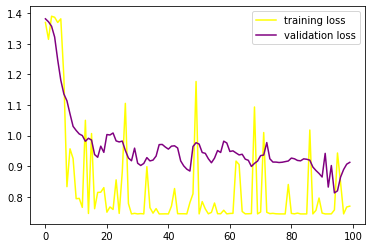

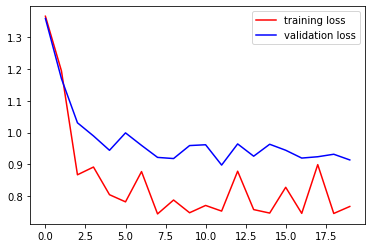

In [31]:
t1 = []
for i in training_loss:
  t1.append(i.cpu().item())


plt.plot(t1,'yellow', label="training loss")
plt.plot(validation_loss, 'purple', label="validation loss")
plt.legend()
plt.show()

t = []
v = []
for i in range(0,20):
  v.append(np.mean(validation_loss[i*4:(i+1)*4]))
  t.append(np.mean(t1[i*4:(i+1)*4]))

plt.plot(t,'red',label='training loss')
plt.plot(v, 'blue', label='validation loss')

plt.legend()
plt.show()

###Test Model

In [32]:
from functools import total_ordering
test_losses = [] # track loss
num_correct = 0
num_sad_correct = 0
num_anger_correct = 0
num_fear_correct = 0
num_disgust_correct = 0
total_s = 0
total_a = 0
total_f = 0
total_d = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

  # Creating new variables for the hidden state, otherwise
  # we'd backprop through the entire training history
  h = tuple([each.data for each in h])
  e=0

  if(train_on_gpu):
    inputs, labels_2 = inputs.cuda(), labels.cuda()

  output, h = net(inputs, h)

  # calculate loss
  test_loss = criterion(output, labels_2.float())
  test_losses.append(test_loss.item())

  highest_value = 0
  high = 0
  counter = 0
  for i in output[0].cpu().detach().numpy():
    if i > highest_value:
      highest_value = i
      high = counter
    counter += 1
  
  pred = [0,0,0,0]
  pred[high] = 1


  # convert output probabilities to predicted class (0 or 1)
  #pred = torch.round(output.squeeze())  # rounds to the nearest integer
  # compare predictions to true label
  #correct_tensor = pred.eq(labels.view_as(pred))

  if labels[0].numpy()[0]==1:
    total_s +=1
    if pred[0] == 1:
      num_sad_correct += 1
      num_correct += 1
  if labels[0].numpy()[1]==1:
    total_a +=1
    if pred[1] == 1:
      num_anger_correct += 1
      num_correct += 1
  if labels[0].numpy()[2]==1:
    total_f +=1
    if pred[2] == 1:
      num_fear_correct += 1
      num_correct += 1
  if labels[0].numpy()[3]==1:
    total_d +=1
    if pred[3] == 1:
      num_disgust_correct += 1
      num_correct += 1

# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data

test_acc = num_correct/len(test_loader.dataset)
test_acc_s = num_sad_correct/total_s
try:
  test_acc_f = num_fear_correct/total_f
except:
  test_acc_f = 0
test_acc_a = num_anger_correct/total_a
test_acc_d = num_disgust_correct/total_d
print("Test accuracy: {:.3f}".format(test_acc))
print("Test sad accuracy: {:.6f}".format(test_acc_s))
print("Test anger accuracy: {:.6f}".format(test_acc_a))
print("Test disgust accuracy: {:.6f}".format(test_acc_f))
print("Test fear accuracy: {:.6f}".format(test_acc_d))

Test loss: 1.227
Test accuracy: 0.517
Test sad accuracy: 0.307692
Test anger accuracy: 0.750000
Test disgust accuracy: 0.000000
Test fear accuracy: 0.714286


##Ukraine Training Without Disgust

###Preparing Data Emoji Ukraine

In [33]:
data_emoji_0["emotion"].value_counts()

print(data_emoji_0["emotion"].value_counts())
data_emoji_0_s = data_emoji_0[data_emoji_0["emotion"] == 0]
data_emoji_0_a = data_emoji_0[data_emoji_0["emotion"] == 1]
data_emoji_0_f = data_emoji_0[data_emoji_0["emotion"] == 2]
data_emoji_0_d = data_emoji_0[data_emoji_0["emotion"] == 3]

data_emoji_0_s = data_emoji_0_s.sample(n=46)
data_emoji_0_a = data_emoji_0_a.sample(n=46)
data_emoji_0_d = data_emoji_0_d.sample(n=46)

data_emoji_0 = data_emoji_0_s.append(data_emoji_0_a,ignore_index=True)
data_emoji_0 = data_emoji_0.append(data_emoji_0_d,ignore_index=True)

data_emoji_0 = shuffle(data_emoji_0)

print(data_emoji_0["emotion"].value_counts())

3    46
1    46
0    46
2     5
Name: emotion, dtype: int64
0    46
3    46
1    46
Name: emotion, dtype: int64


In [34]:
import re
from string import punctuation

all_tweets_emoji_0 = list()

for t in data_emoji_0["tweet"]:
  #t = 'a ' + t
  t = re.sub("(?:\s)@[^, ]*", '', t)
  #t = re.sub("(?:\s)#[^, ]*", '', t)
  t = t[4:]
  t = t.lower()
  t = "".join([ch for ch in t if ch not in punctuation])
  all_tweets_emoji_0.append(t)

all_text = " ".join(all_tweets_emoji_0)
all_words = all_text.split()

In [35]:
from collections import Counter 
# Count all the words using Counter Method
count_words = Counter(all_words)
total_words=len(all_words)
sorted_words=count_words.most_common(total_words)
print("Top ten occuring words : ",sorted_words[:10])

Top ten occuring words :  [('the', 146), ('to', 83), ('ukraine', 71), ('and', 60), ('in', 46), ('of', 43), ('is', 39), ('russia', 38), ('mined', 32), ('a', 31)]


In [36]:
vocab_to_int={w:i+1 for i,(w,c) in enumerate(sorted_words)}

In [37]:
encoded_tweets=list()
iter_1 = 0
iter_2 = 0
for t in all_tweets_emoji_0:
  encoded_tweet=list()
  for word in t.split():
    if word not in vocab_to_int.keys():
      #if word is not available in vocab_to_int put 0 in that place
      encoded_tweet.append(0)
      iter_1 += 1
    else:
      iter_2 += 1
      encoded_tweet.append(vocab_to_int[word])
  encoded_tweets.append(encoded_tweet)
print(iter_1)
print(iter_2)
print(encoded_tweets[0])

0
3373
[412, 77, 18, 2, 8, 24, 54, 25, 26, 78, 26, 79]


In [38]:
sequence_length = 0
for i, tweet in enumerate(encoded_tweets):
  if len(tweet) > sequence_length:
    sequence_length = len(tweet)

features_emoji_0 = []
for i, tweet in enumerate(encoded_tweets):
  tweet_len=len(tweet)
  if (tweet_len<=sequence_length):
    zeros=list(np.zeros(sequence_length-tweet_len))
    new=zeros+tweet
  else:
    new=tweet[:sequence_length]
  features_emoji_0.append(np.array(new))

###Train Model

In [39]:
train_x=features_emoji_0[:int(0.7*len(features_emoji_0))]
train_y=data_emoji_0["emotion"][:int(0.7*len(features_emoji_0))]
valid_x=features_emoji_0[int(0.7*len(features_emoji_0)):int(0.8*len(features_emoji_0))]
valid_y=data_emoji_0["emotion"][int(0.7*len(features_emoji_0)):int(0.8*len(features_emoji_0))]
test_x=features_emoji_0[int(0.8*len(features_emoji_0)):]
test_y=data_emoji_0["emotion"][int(0.8*len(features_emoji_0)):]
print(len(train_y), len(valid_y), len(test_y))

96 14 28


In [40]:
from torch.utils.data import DataLoader, TensorDataset

#create Tensor Dataset
train_data=TensorDataset(torch.FloatTensor(train_x).to(torch.int64), F.one_hot(torch.FloatTensor(train_y.to_numpy(dtype=np.float64)).to(torch.int64)))
valid_data=TensorDataset(torch.FloatTensor(valid_x).to(torch.int64), F.one_hot(torch.FloatTensor(valid_y.to_numpy(dtype=np.float64)).to(torch.int64)))
test_data=TensorDataset(torch.FloatTensor(test_x).to(torch.int64), F.one_hot(torch.FloatTensor(test_y.to_numpy(dtype=np.float64)).to(torch.int64)))

#dataloader
batch_size=64
train_loader=DataLoader(train_data, batch_size=1, shuffle=True)
valid_loader=DataLoader(valid_data, batch_size=1, shuffle=True)
test_loader=DataLoader(test_data, batch_size=1, shuffle=True)

In [41]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([1, 47])
Sample input: 
 tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0, 33, 15,  9,  1, 11, 34,  9,  1, 35, 11, 13, 14, 36, 37, 38, 39,
          2, 40,  1, 30, 22, 20, 41, 42, 43, 44, 45]])
Sample label size:  torch.Size([1, 4])
Sample label: 
 tensor([[0, 1, 0, 0]])


In [42]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 4
embedding_dim = 400
hidden_dim = 256
n_layers = 1

net = SentimentalLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentalLSTM(
  (embedding): Embedding(1198, 400)
  (lstm): LSTM(400, 256, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=4, bias=True)
  (sigmoid): Sigmoid()
  (softAct): Softmax(dim=None)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [43]:
# loss and optimization functions
lr=0.0005

#criterion = nn.CrossEntropyLoss(reduction='sum')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# training params

epochs = 20# 3-4 is approx where I noticed the validation loss stop decreasing

training_loss=[]
validation_loss=[]

counter = 0
print_every = 20
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs=inputs.cuda()
            labels=labels.cuda()
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()
        # get the output from the model
        output, h = net(inputs, h)
        # calculate the loss and perform backprop
        loss = criterion(output, labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            error = 0
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])
                if(train_on_gpu):
                  inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, labels.float())
                val_losses.append(val_loss.item())
                 
            training_loss.append(loss)
            validation_loss.append(np.mean(val_losses))
            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))


Epoch: 1/20... Step: 20... Loss: 1.460503... Val Loss: 1.367617
Epoch: 1/20... Step: 40... Loss: 1.417198... Val Loss: 1.358983
Epoch: 1/20... Step: 60... Loss: 1.368103... Val Loss: 1.343548
Epoch: 1/20... Step: 80... Loss: 1.324772... Val Loss: 1.301929
Epoch: 2/20... Step: 100... Loss: 0.949205... Val Loss: 1.259369
Epoch: 2/20... Step: 120... Loss: 1.396150... Val Loss: 1.214234
Epoch: 2/20... Step: 140... Loss: 1.214477... Val Loss: 1.155773
Epoch: 2/20... Step: 160... Loss: 1.080732... Val Loss: 1.156528
Epoch: 2/20... Step: 180... Loss: 1.174145... Val Loss: 1.092636
Epoch: 3/20... Step: 200... Loss: 0.970870... Val Loss: 1.057059
Epoch: 3/20... Step: 220... Loss: 0.979077... Val Loss: 1.015481
Epoch: 3/20... Step: 240... Loss: 0.866601... Val Loss: 1.042567
Epoch: 3/20... Step: 260... Loss: 1.033746... Val Loss: 1.020533
Epoch: 3/20... Step: 280... Loss: 0.783363... Val Loss: 0.991566
Epoch: 4/20... Step: 300... Loss: 0.863745... Val Loss: 0.987842
Epoch: 4/20... Step: 320... L

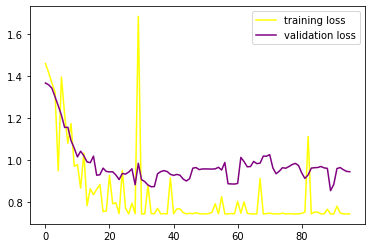

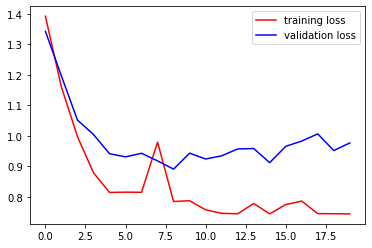

In [44]:
t1 = []
for i in training_loss:
  t1.append(i.cpu().item())


plt.plot(t1,'yellow', label="training loss")
plt.plot(validation_loss, 'purple', label="validation loss")
plt.legend()
plt.show()

t = []
v = []
for i in range(0,20):
  v.append(np.mean(validation_loss[i*4:(i+1)*4]))
  t.append(np.mean(t1[i*4:(i+1)*4]))

plt.plot(t,'red',label='training loss')
plt.plot(v, 'blue', label='validation loss')

plt.legend()
plt.show()

###Test Model

In [45]:
from functools import total_ordering
test_losses = [] # track loss
num_correct = 0
num_sad_correct = 0
num_anger_correct = 0
num_fear_correct = 0
num_disgust_correct = 0
total_s = 0
total_a = 0
total_f = 0
total_d = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

  # Creating new variables for the hidden state, otherwise
  # we'd backprop through the entire training history
  h = tuple([each.data for each in h])
  e=0

  if(train_on_gpu):
    inputs, labels_2 = inputs.cuda(), labels.cuda()

  output, h = net(inputs, h)

  # calculate loss
  test_loss = criterion(output, labels_2.float())
  test_losses.append(test_loss.item())

  highest_value = 0
  high = 0
  counter = 0
  for i in output[0].cpu().detach().numpy():
    if i > highest_value:
      highest_value = i
      high = counter
    counter += 1
  
  pred = [0,0,0,0]
  pred[high] = 1


  # convert output probabilities to predicted class (0 or 1)
  #pred = torch.round(output.squeeze())  # rounds to the nearest integer
  # compare predictions to true label
  #correct_tensor = pred.eq(labels.view_as(pred))

  if labels[0].numpy()[0]==1:
    total_s +=1
    if pred[0] == 1:
      num_sad_correct += 1
      num_correct += 1
  if labels[0].numpy()[1]==1:
    total_a +=1
    if pred[1] == 1:
      num_anger_correct += 1
      num_correct += 1
  if labels[0].numpy()[2]==1:
    total_f +=1
    if pred[2] == 1:
      num_fear_correct += 1
      num_correct += 1
  if labels[0].numpy()[3]==1:
    total_d +=1
    if pred[3] == 1:
      num_disgust_correct += 1
      num_correct += 1

# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data

test_acc = num_correct/len(test_loader.dataset)
test_acc_s = num_sad_correct/total_s
test_acc_a = num_anger_correct/total_a
test_acc_d = num_disgust_correct/total_d
print("Test accuracy: {:.3f}".format(test_acc))
print("Test sad accuracy: {:.6f}".format(test_acc_s))
print("Test anger accuracy: {:.6f}".format(test_acc_a))
print("Test fear accuracy: {:.6f}".format(test_acc_d))

Test loss: 1.029
Test accuracy: 0.679
Test sad accuracy: 0.625000
Test anger accuracy: 0.625000
Test fear accuracy: 0.750000
